# Build Target Model

Here we expand our on target rules to include information about the target site.
We consider four feature classes when building this model:

1. Position within a gene, including sgRNA oriention
2. Protein Domain information: whether a guide targets within an annotated protein domain
3. Sequence conservation
4. Amino acid idenity and physiochemical properties


In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import joblib
import sglearn
import seaborn as sns
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from scipy import stats
import optuna
from joblib import Parallel, delayed
from datetime import datetime
import numpy as np
import gpplot

import target_featurization as ft
from core import (get_predictive_performance,
                  setup_plots,
                  plot_spearman_heatmap,
                  plot_model_performance,
                  get_tidy_cv_df)
from datasets import dataset_list, get_sg_groups_df

In [2]:
setup_plots()

In [3]:
def get_fold_predictions(fold, fold_df, model_name, features,
                         aa_seq_df,
                         protein_domain_df,
                         conservation_df,
                         base_model=Pipeline([('imputer', SimpleImputer(strategy='median')),
                                              ('regressor', LGBMRegressor(random_state=7, n_jobs=8))]),
                         aa_width=8, aa_features=None,
                         cons_small_width=2, cons_large_width=32):
    """Get predictions for a given fold

    :param fold: int
    :param fold_df: DataFrame
    :param model_name: str
    :param features: list
    :param aa_seq_df: DataFrame, fed into target featurization
    :param protein_domain_df: DataFrame, fed into target featurization
    :param conservation_df: DataFrame, fed into target featurization
    :param base_model: Pipeline(Imputer, Regressor)
    :param aa_width: int
    :param aa_features: list or None, see featurize_aa_seqs for options. Will default to best options if None
    :param cons_small_width: int
    :param cons_large_width: int
    :return: DataFrame, test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                      aa_features=aa_features,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df,
                                                                      cons_small_width=cons_small_width,
                                                                      cons_large_width=cons_large_width)
    X_train = train_feature_df[train_feature_cols]
    y_train = train_df['Residual Activity']
    test_df = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df, aa_width=aa_width,
                                                                    aa_features=aa_features,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df,
                                                                    cons_small_width=cons_small_width,
                                                                    cons_large_width=cons_large_width)
    X_test = test_feature_df[test_feature_cols]
    model = clone(base_model)
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def lgbm_training_iteration(fold_df, train_index, features,
                            aa_seq_df, protein_domain_df,
                            conservation_df,
                            test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param features: list, features to us
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :param test_index: list-like
    :param base_model: Pipeline (Imputer, Regressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=features,
                                                                      aa_seq_df=aa_seq_df,
                                                                      protein_domain_df=protein_domain_df,
                                                                      conservation_df=conservation_df)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(test_df,
                                                                    features=features,
                                                                    aa_seq_df=aa_seq_df,
                                                                    protein_domain_df=protein_domain_df,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    r2 = r2_score(test_predictions['Residual Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df, features, aa_seq_df, protein_domain_df, conservation_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :param features: list
    :param aa_seq_df: DataFrame
    :param protein_domain_df: DataFrame
    :param conservation_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for Pipeline

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('regressor',
                           LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                                         num_leaves=num_leaves,
                                         min_child_samples=min_child_samples))])
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, train_index, features,
                                          aa_seq_df, protein_domain_df,
                                          conservation_df,
                                          test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective


## Reading Data

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

## Loading Datasets

In [5]:
train_data_list = list()
for ds in dataset_list:
    if (ds.name in train_data_names) and ds.endogenous:
        train_data_list.append(ds)

sg_groups_df = get_sg_groups_df(train_data_list)
sg_groups_df = ft.add_target_columns(sg_groups_df)

Context sequences with multiple targets: 0


## Protein Domain Features

In [6]:
domain_model_matrix = ft.get_protein_domain_features(sg_groups_df, protein_domains, sources=None)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


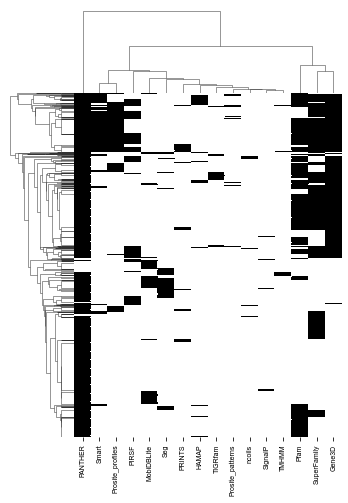

In [7]:
g = sns.clustermap(domain_model_matrix.set_index(['sgRNA Context Sequence', 'Transcript Base']),
                   cmap='binary', cbar_pos=None, metric='hamming',
                   yticklabels=False, figsize=(5, 7))
g.ax_heatmap.set_ylabel("")
gpplot.savefig('../figures/domain_clustermap.pdf')

In [8]:
long_domain_model_matrix = domain_model_matrix.melt(id_vars=['Transcript Base', 'sgRNA Context Sequence'],
                                                    var_name='source',
                                                    value_name='present')
long_domain_model_matrix = long_domain_model_matrix[long_domain_model_matrix['present'] == 1]
(long_domain_model_matrix[['Transcript Base', 'source']].value_counts()
 .reset_index()['source'].value_counts())

PANTHER             46
Pfam                44
Gene3D              41
SuperFamily         35
Seg                 31
Prosite_patterns    30
MobiDBLite          22
Smart               18
Prosite_profiles    15
PIRSF               11
HAMAP               11
TMHMM                9
SignalP              8
PRINTS               7
TIGRfam              7
ncoils               5
Name: source, dtype: int64

## Conservation of Protein Domains

We'll merge conservation scores with the protein domain matrix to understand how protein domains are conserved

In [9]:
transcript_bases = list(sg_groups_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

In [10]:
conservation_aa_i = conservation_df.copy()
conservation_aa_i['aa_i'] = (conservation_aa_i['target position'] - 1) // 3 + 1
conservation_aa_i['loc_id'] = conservation_aa_i['Transcript Base'] + conservation_aa_i['aa_i'].astype(str)
# Filter sifts
conservation_domains = (conservation_aa_i.merge(protein_domains[protein_domains['type'] != 'sifts'],
                                                how='inner',
                                                on='Transcript Base'))
conservation_domains = (conservation_domains[conservation_domains['aa_i']
                        .between(conservation_domains['start'], conservation_domains['end'])])
conservation_non_domains = conservation_aa_i[~conservation_aa_i['loc_id'].isin(conservation_domains['loc_id'])]
conservation_cat = (pd.concat([conservation_domains, conservation_non_domains])
                    .reset_index(drop=True))
conservation_cat['type'] = conservation_cat['type'].fillna('None')
conservation_cat_summary = (conservation_cat.groupby(['type', 'genome'])
                            .agg(median_conservation = ('conservation', 'median'),
                                 n_obs = ('conservation', 'count'))
                            .reset_index()
                            .sort_values('median_conservation'))
conservation_cat_summary['name'] = (conservation_cat_summary['type'] +
                                    '(n=' +
                                    conservation_cat_summary['n_obs'].astype(str) +
                                    ')')
hg_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('hg')]
mm_conservation_cat_summary = conservation_cat_summary[conservation_cat_summary['genome'].str.contains('mm')]
hg_conservation_cat = conservation_cat.merge(hg_conservation_cat_summary, how='inner')
hg_conservation_cat['name'] = pd.Categorical(hg_conservation_cat['name'],
                                             categories=hg_conservation_cat_summary['name'])
mm_conservation_cat = conservation_cat.merge(mm_conservation_cat_summary, how='inner')
mm_conservation_cat['name'] = pd.Categorical(mm_conservation_cat['name'],
                                             categories=mm_conservation_cat_summary['name'])

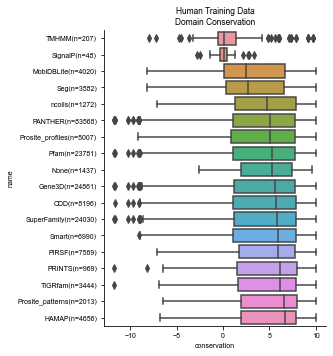

In [11]:
sns.catplot(data=hg_conservation_cat, y='name', x='conservation', kind='box', height=4.5)
plt.title('Human Training Data\nDomain Conservation')
gpplot.savefig('../figures/human_domain_conservation.pdf')

Text(0.5, 1.0, 'Mouse Training Data\nDomain Conservation')

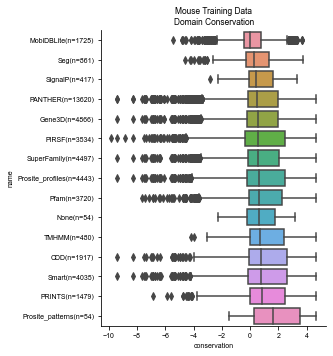

In [12]:
sns.catplot(data=mm_conservation_cat, y='name', x='conservation', kind='box', height=4.5)
plt.title('Mouse Training Data\nDomain Conservation')

## Calculating Residuals

In [13]:
sg_df_residuals = sg_groups_df.copy()
seq_X = sglearn.featurize_guides(sg_df_residuals['sgRNA Context Sequence'])
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))

dataset
Doench2014_human     (0.7727808036766911, 2.800177363791138e-198)
Doench2014_mouse      (0.7298038255759217, 5.76440723823292e-195)
Doench2016                              (0.6719812460269855, 0.0)
Wang2014            (0.7652273559131587, 2.5822266619624947e-197)
dtype: object

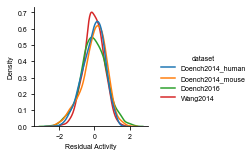

In [14]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']
sns.displot(data=sg_df_residuals, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False, height=2.2)
gpplot.savefig('../figures/model_residuals.pdf')

## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [15]:
tidy_cv_df = get_tidy_cv_df(sg_df_residuals, random_state=1)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
19,0,Doench2014_human,1
18,1,Doench2014_human,1
17,2,Doench2014_human,1
16,2,Doench2014_mouse,1
1,0,Doench2014_mouse,2
15,0,Doench2016,2
14,0,Wang2014,2
13,1,Doench2014_mouse,2
12,1,Doench2016,2
11,1,Wang2014,2


- Training sizes vary from 5,258 - 4,253 sgRNAs
- Testing sizes vary from 1,469 - 464 sgRNAs

In [16]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,464
0,0,True,5258
6,1,False,1441
3,1,True,4281
8,2,False,1093
1,2,True,4629
5,3,False,1469
4,3,True,4253
7,4,False,1255
2,4,True,4467


As expected each gene target (gene) only appears in one set in each fold

In [17]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 [['cv', 'target']].value_counts()  # will show up twice if train == False and True
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Testing Feature Sets

### Amino Acid Width

In [18]:
aa_width_prediction_list = []
aa_widths = [2, 4, 8, 16, 32]
for width in aa_widths:
    print(width)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name='aa ' + str(width),
                                           features=['aa'],
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df,
                                           aa_width=width, aa_features=None)
        aa_width_prediction_list.append(predictions)
    print('\n')

aa_width_predictive_performance, aa_width_agg_performance = get_predictive_performance(aa_width_prediction_list,
                                                                                       'Residual Activity')

2
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


4
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


8
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




We'll use a width of 8 as our default for Amino Acid featurization

In [19]:
aa_width_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,aa 8,0.155750,0.096045,0.167914
1,aa 32,0.146883,0.147092,0.102576
2,aa 16,0.124414,0.144679,0.156527
3,aa 4,0.124080,0.042358,0.108148
4,aa 2,0.073640,0.080223,0.090808


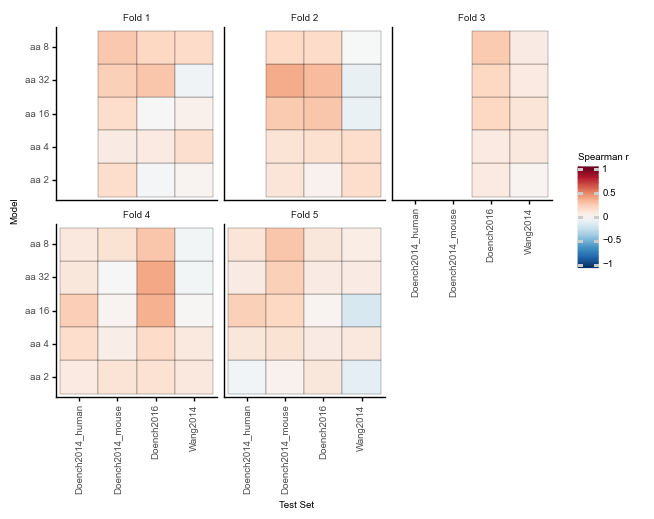

<ggplot: (8786451289272)>

In [20]:
plot_spearman_heatmap(aa_width_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_model_aa_width.pdf


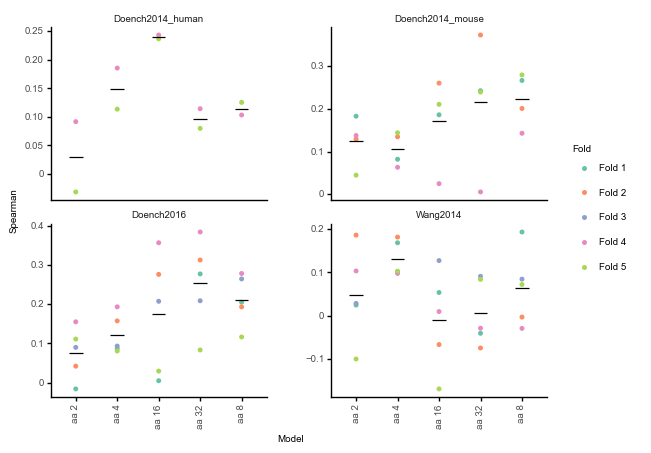

<ggplot: (8786452119327)>

In [21]:
g = plot_model_performance(aa_width_predictive_performance)
g.save('../figures/target_model_aa_width.pdf', width=3, height=3)
g

### Conservation Width

In [22]:
cons_width_prediction_list = []
cons_small_widths = [2, 4, 8]
cons_large_widths = [16, 32, 64]
for small_width in cons_small_widths:
    print('Small: ' + str(small_width))
    for large_width in cons_large_widths:
        print('Large: ' + str(large_width))
        for fold, df in tidy_cv_df.groupby('cv'):
            print('Fold: ' + str(fold))
            predictions = get_fold_predictions(fold, df, model_name='cons ' + str(small_width) +  ', ' +
                                                                    str(large_width),
                                               features=['conservation'],
                                               aa_seq_df=aa_seqs,
                                               protein_domain_df=protein_domains,
                                               conservation_df=conservation_df,
                                               cons_small_width=small_width,
                                               cons_large_width=large_width)
            cons_width_prediction_list.append(predictions)
        print('\n')
    print('\n')

cons_width_predictive_performance, cons_width_agg_performance = get_predictive_performance(cons_width_prediction_list,
                                                                                           'Residual Activity')

Small: 2
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 4
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




Small: 8
Large: 16
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 32
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Large: 64
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4






It looks like a small width of 2 and a large width of 32 is optimal for conservation

In [23]:
cons_width_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,"cons 2, 32",0.059118,0.135375,0.065611
1,"cons 4, 64",0.046569,0.136632,0.044104
2,"cons 4, 16",0.038369,0.101839,0.039882
3,"cons 2, 16",0.038218,0.103206,0.041028
4,"cons 4, 32",0.029056,0.131926,0.019093
5,"cons 8, 32",0.023937,0.127966,0.027960
6,"cons 8, 64",0.023401,0.116103,0.024204
7,"cons 2, 64",0.020744,0.142515,0.021873
8,"cons 8, 16",0.013235,0.118143,0.011939


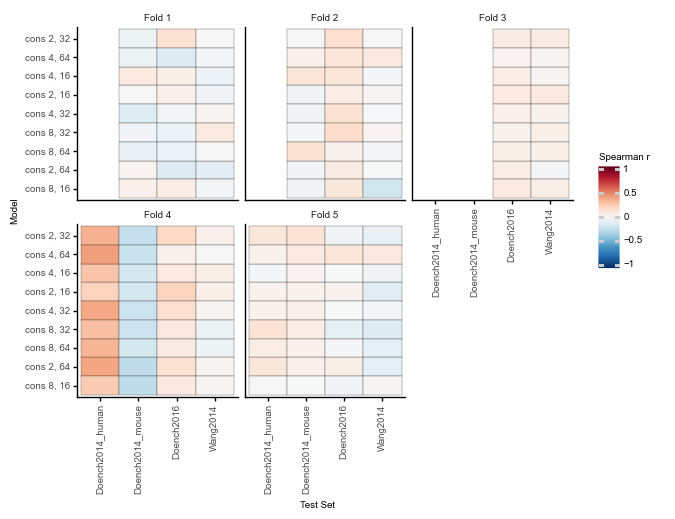

<ggplot: (8786455442158)>

In [24]:
plot_spearman_heatmap(cons_width_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_model_cons_width.pdf


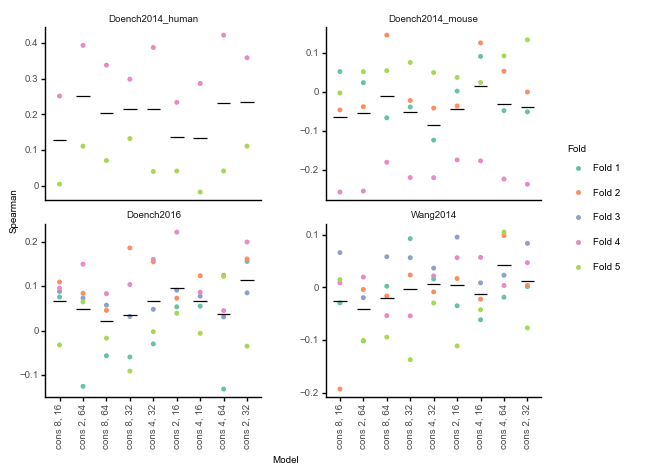

<ggplot: (8786452344917)>

In [25]:
g = plot_model_performance(cons_width_predictive_performance)
g.save('../figures/target_model_cons_width.pdf', width=4, height=3)
g

### Single Feature Sets

In [26]:
single_prediction_list = []
features = ['position', 'aa', 'domain', 'conservation']
for feature in features:
    print(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name=feature,
                                           features=[feature],
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        single_prediction_list.append(predictions)
    print('\n')

single_predictive_performance, single_agg_performance = get_predictive_performance(single_prediction_list,
                                                                                   'Residual Activity')


position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




All features are able to positively predict the residual activity of sgRNAs

In [27]:
single_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,domain,0.157423,0.159584,0.192060
1,aa,0.155750,0.096045,0.167914
2,position,0.117039,0.152116,0.104508
3,conservation,0.059118,0.135375,0.065611


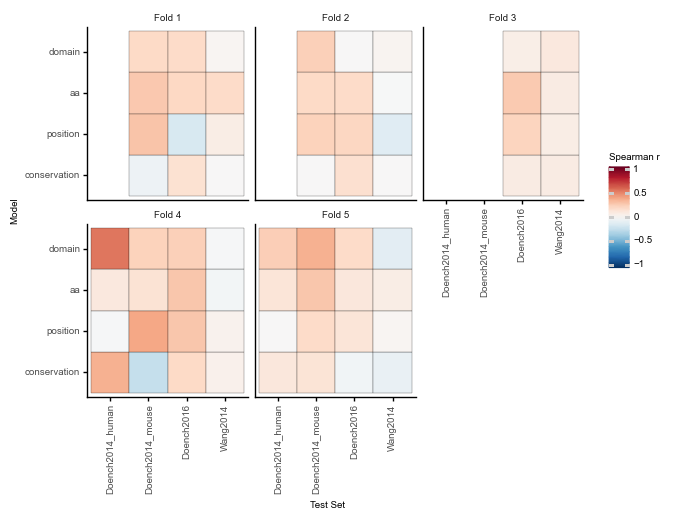

<ggplot: (8786452004765)>

In [28]:
plot_spearman_heatmap(single_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.7 x 2.7 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_model_single_performance.pdf


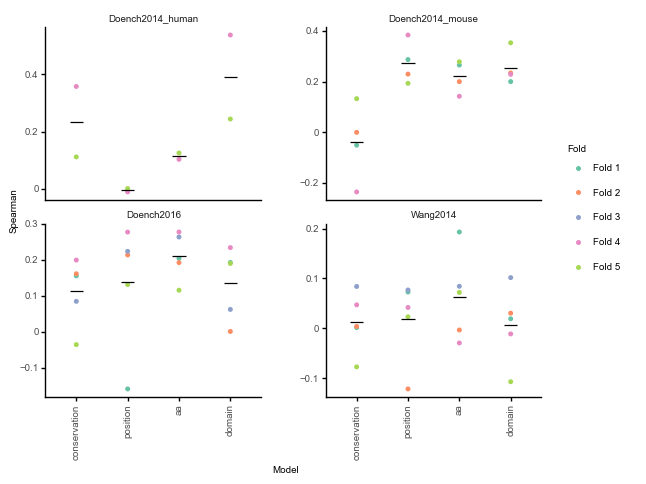

<ggplot: (8786458094939)>

In [29]:
g = plot_model_performance(single_predictive_performance)
g.save('../figures/target_model_single_performance.pdf', width=2.7, height=2.7)
g

### Complete Feature Set

All features together are better than any one alone.

In [30]:
complete_feature_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions = get_fold_predictions(fold, df, model_name='All',
                                       features=features,
                                       aa_seq_df=aa_seqs,
                                       protein_domain_df=protein_domains,
                                       conservation_df=conservation_df)
    complete_feature_list.append(predictions)

complete_predictive_performance, complete_agg_performance = get_predictive_performance(complete_feature_list +
                                                                                       single_prediction_list,
                                                                                       'Residual Activity')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [31]:
complete_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All,0.225727,0.140962,0.224005
1,domain,0.157423,0.159584,0.192060
2,aa,0.155750,0.096045,0.167914
3,position,0.117039,0.152116,0.104508
4,conservation,0.059118,0.135375,0.065611


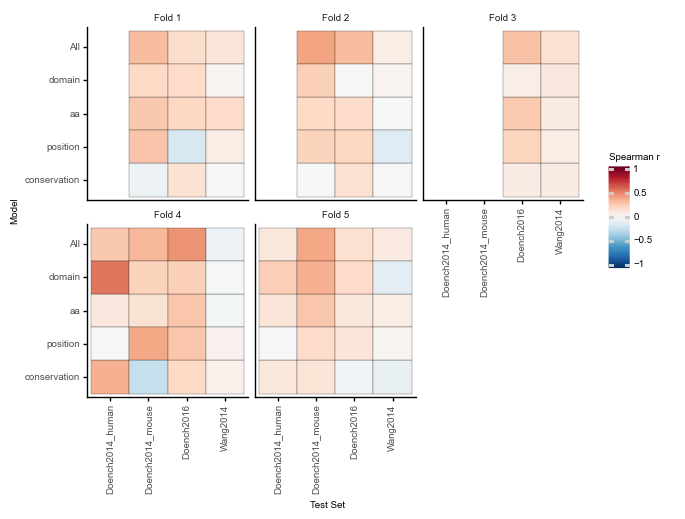

<ggplot: (8786436259660)>

In [32]:
plot_spearman_heatmap(complete_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_all_performance.pdf


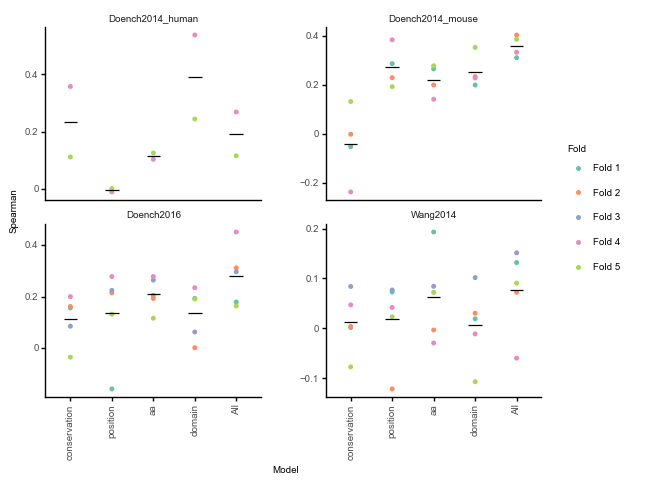

<ggplot: (8786445992599)>

In [33]:
g = plot_model_performance(complete_predictive_performance)
g.save('../figures/target_all_performance.pdf', width=3, height=3)
g

### Leave One Set Out

We can remove conservation features and improve our results

In [34]:
leave_one_prediction_list = []
for feature in features:
    print(feature)
    curr_features = features.copy()
    curr_features.remove(feature)
    for fold, df in tidy_cv_df.groupby('cv'):
        print('Fold: ' + str(fold))
        predictions = get_fold_predictions(fold, df, model_name='No ' + feature,
                                           features=curr_features,
                                           aa_seq_df=aa_seqs,
                                           protein_domain_df=protein_domains,
                                           conservation_df=conservation_df)
        leave_one_prediction_list.append(predictions)
    print('\n')

leave_one_predictive_performance, leave_one_agg_performance = get_predictive_performance(
    leave_one_prediction_list + complete_feature_list, 'Residual Activity')

position
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


aa
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


domain
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


conservation
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4




In [35]:
leave_one_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,No conservation,0.229482,0.143149,0.236545
1,All,0.225727,0.140962,0.224005
2,No domain,0.198725,0.149005,0.163438
3,No position,0.190091,0.157033,0.165991
4,No aa,0.183203,0.202495,0.208335


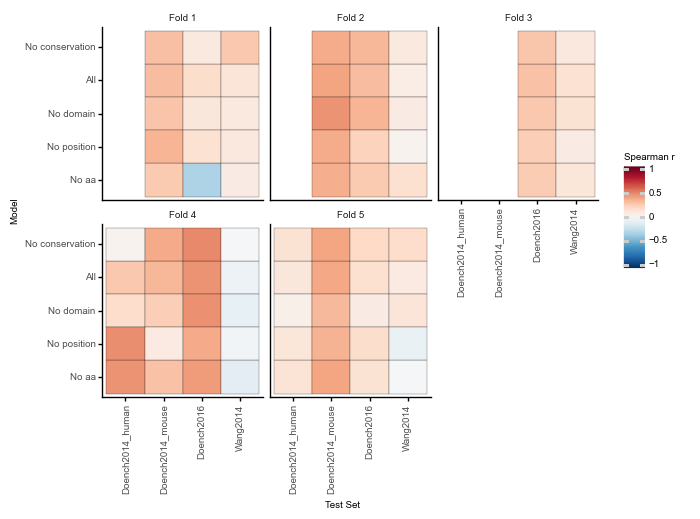

<ggplot: (8786434012212)>

In [36]:
plot_spearman_heatmap(leave_one_predictive_performance)

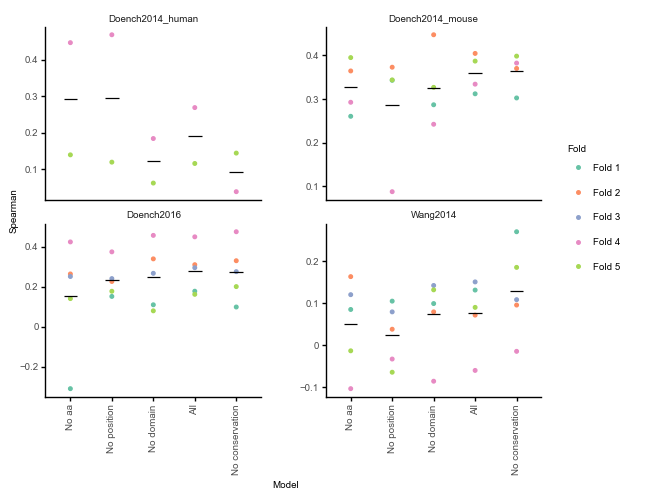

<ggplot: (8786454854054)>

In [37]:
plot_model_performance(leave_one_predictive_performance)

## Hyperparameter Tuning

We'll use optuna to tune hyperparameters for the model

In [38]:
n_trials = 50
model_name = 'No Conservation + TPE ' + str(n_trials)
final_features = features.copy().remove('conservation')

In [39]:
tpe_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_lgbm_objective(fold_train_data, features=final_features,
                                   aa_seq_df=aa_seqs, protein_domain_df=protein_domains,
                                   conservation_df=conservation_df)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_feature_df, train_feature_cols = ft.build_target_feature_df(train_df,
                                                                      features=final_features,
                                                                      aa_seq_df=aa_seqs,
                                                                      protein_domain_df=protein_domains,
                                                                      conservation_df=conservation_df)
    X_train_val = train_feature_df[train_feature_cols] # train and validation data
    y_train_val = train_df['Residual Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = Pipeline([('imputer', SimpleImputer(strategy='median')),
                      ('regressor',
                       LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                                     **trial.params))])
    model.fit(X_train, y_train,
              regressor__early_stopping_rounds=20,
              regressor__eval_set=[(X_val, y_val)],
              regressor__verbose=1000)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df, test_feature_cols = ft.build_target_feature_df(fold_test_data,
                                                                    features=final_features,
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df)
    X_test = test_feature_df[test_feature_cols]
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = model_name
    test_predictions['fold'] = fold
    tpe_prediction_list.append(test_predictions)


[I 2021-06-12 08:02:41,549] A new study created in memory with name: no-name-9a8a234d-b8dd-45e3-a04d-ce89e496eba3


Fold: 0


[I 2021-06-12 08:02:49,541] Trial 0 finished with value: 0.08315253276561159 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.08315253276561159.
[I 2021-06-12 08:02:53,831] Trial 1 finished with value: 0.08735075239608828 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 1 with value: 0.08735075239608828.
[I 2021-06-12 08:02:57,709] Trial 2 finished with value: 0.09832387634844941 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 2 with value: 0.09832387634844941.
[I 2021-06-12 08:03:01,977] Trial 3 finished with value: 0.07516315936282758 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 2 with value: 0.09832387634844941.
[I 2021-06-12 08:03:05,860] Trial 4 finished with value: 0.08884051465957517 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 2 with value: 0.09832387634844941.
[I 2021-06-12 08:03:09,669] Trial 5 finished with value: 0

Number of finished trials: 50
Training Time: 0:02:41.970121
Best trial:
  Value: 0.09987461612601498
  Params: 
    num_leaves: 13
    min_child_samples: 148
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[926]	valid_0's l2: 0.348914


[I 2021-06-12 08:05:25,629] A new study created in memory with name: no-name-b7e17cfc-a300-41c6-96f4-7bda63c83b21


Fold: 1


[I 2021-06-12 08:05:27,881] Trial 0 finished with value: 0.05245705919752201 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.05245705919752201.
[I 2021-06-12 08:05:30,397] Trial 1 finished with value: 0.04982716877931683 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.05245705919752201.
[I 2021-06-12 08:05:32,696] Trial 2 finished with value: 0.04955612651917709 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.05245705919752201.
[I 2021-06-12 08:05:35,606] Trial 3 finished with value: 0.01006707010278889 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.05245705919752201.
[I 2021-06-12 08:05:37,925] Trial 4 finished with value: 0.0485870933690616 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.05245705919752201.
[I 2021-06-12 08:05:40,279] Trial 5 finished with value: 0.

Number of finished trials: 50
Training Time: 0:01:59.300550
Best trial:
  Value: 0.07073603070438046
  Params: 
    num_leaves: 207
    min_child_samples: 227
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[915]	valid_0's l2: 0.348135


[I 2021-06-12 08:07:27,090] A new study created in memory with name: no-name-df9cab26-a819-4e81-a44f-793755b57306


Fold: 2


[I 2021-06-12 08:07:30,008] Trial 0 finished with value: 0.11607712935454859 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.11607712935454859.
[I 2021-06-12 08:07:32,930] Trial 1 finished with value: 0.11449586825071167 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.11607712935454859.
[I 2021-06-12 08:07:35,891] Trial 2 finished with value: 0.11418103888646443 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.11607712935454859.
[I 2021-06-12 08:07:38,974] Trial 3 finished with value: 0.10010534869861602 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 0 with value: 0.11607712935454859.
[I 2021-06-12 08:07:41,817] Trial 4 finished with value: 0.11573387874813128 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 0 with value: 0.11607712935454859.
[I 2021-06-12 08:07:44,709] Trial 5 finished with value: 0

Number of finished trials: 50
Training Time: 0:02:27.545464
Best trial:
  Value: 0.12268145405692424
  Params: 
    num_leaves: 8
    min_child_samples: 138
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[788]	valid_0's l2: 0.366254


[I 2021-06-12 08:09:56,648] A new study created in memory with name: no-name-7b4cfff0-d8e7-486d-9f07-25f5a7209274


Fold: 3


[I 2021-06-12 08:09:59,874] Trial 0 finished with value: 0.034954692064474525 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.034954692064474525.
[I 2021-06-12 08:10:02,713] Trial 1 finished with value: 0.03383427406570501 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.034954692064474525.
[I 2021-06-12 08:10:05,267] Trial 2 finished with value: 0.025616762305377506 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 0 with value: 0.034954692064474525.
[I 2021-06-12 08:10:08,633] Trial 3 finished with value: 0.03537807083662967 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 3 with value: 0.03537807083662967.
[I 2021-06-12 08:10:11,425] Trial 4 finished with value: 0.03552497515777009 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 4 with value: 0.03552497515777009.
[I 2021-06-12 08:10:14,091] Trial 5 finished with val

Number of finished trials: 50
Training Time: 0:02:23.952715
Best trial:
  Value: 0.06349019692921824
  Params: 
    num_leaves: 8
    min_child_samples: 52
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[448]	valid_0's l2: 0.356139


[I 2021-06-12 08:12:22,364] A new study created in memory with name: no-name-cdb3dddb-4568-43c7-aa07-5ae932653041


Fold: 4


[I 2021-06-12 08:12:25,297] Trial 0 finished with value: 0.07039546344212808 and parameters: {'num_leaves': 27, 'min_child_samples': 202}. Best is trial 0 with value: 0.07039546344212808.
[I 2021-06-12 08:12:28,304] Trial 1 finished with value: 0.06966788970379297 and parameters: {'num_leaves': 117, 'min_child_samples': 188}. Best is trial 0 with value: 0.07039546344212808.
[I 2021-06-12 08:12:31,756] Trial 2 finished with value: 0.08152307906426744 and parameters: {'num_leaves': 251, 'min_child_samples': 142}. Best is trial 2 with value: 0.08152307906426744.
[I 2021-06-12 08:12:34,771] Trial 3 finished with value: 0.07184097809368675 and parameters: {'num_leaves': 132, 'min_child_samples': 25}. Best is trial 2 with value: 0.08152307906426744.
[I 2021-06-12 08:12:37,933] Trial 4 finished with value: 0.07828586263627266 and parameters: {'num_leaves': 74, 'min_child_samples': 132}. Best is trial 2 with value: 0.08152307906426744.
[I 2021-06-12 08:12:41,003] Trial 5 finished with value: 0

Number of finished trials: 50
Training Time: 0:02:56.765100
Best trial:
  Value: 0.1070499367417157
  Params: 
    num_leaves: 8
    min_child_samples: 88
Training until validation scores don't improve for 20 rounds
[1000]	valid_0's l2: 0.376834
Early stopping, best iteration is:
[1056]	valid_0's l2: 0.376198


Tuning hyperparameters improves performance quite a bit

In [40]:
top_features = [df for df in leave_one_prediction_list if (df['model_name'] == 'No conservation').all()]
tpe_predictive_performance, tpe_agg_performance = get_predictive_performance(
    top_features + tpe_prediction_list, 'Residual Activity')

In [41]:
tpe_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,No Conservation + TPE 50,0.267890,0.154278,0.280032
1,No conservation,0.229482,0.143149,0.236545


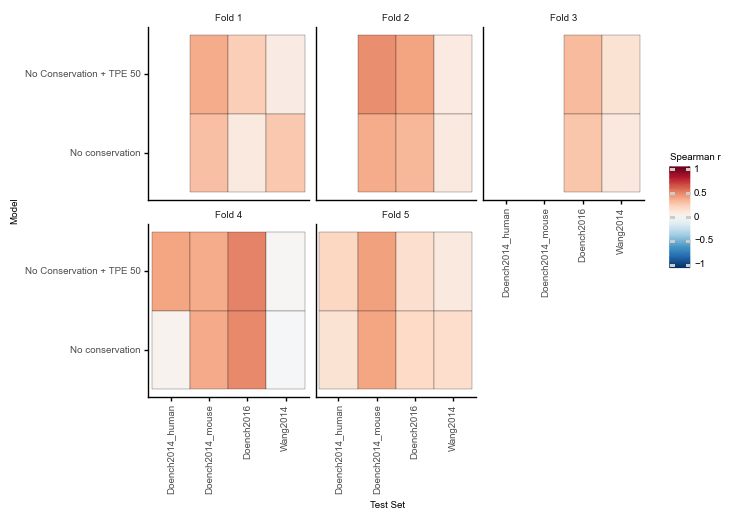

<ggplot: (8786458094960)>

In [42]:
plot_spearman_heatmap(tpe_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 2.5 x 2.5 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/target_model_tpe_performance.pdf


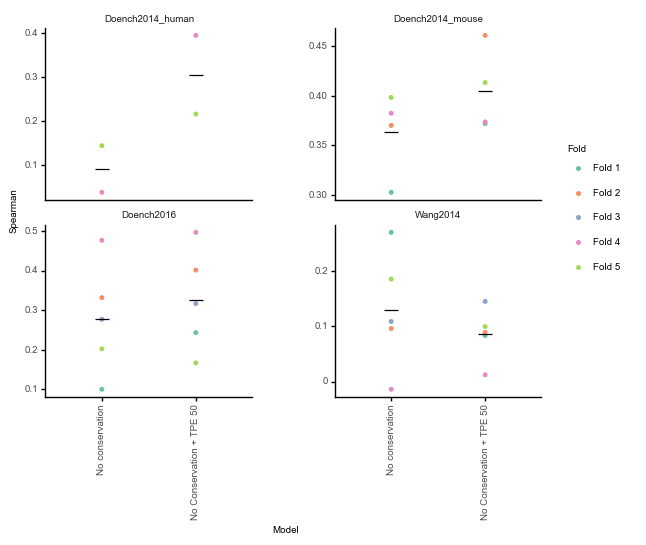

<ggplot: (8786455433590)>

In [43]:
g = plot_model_performance(tpe_predictive_performance, wspace=0.4)
g.save('../figures/target_model_tpe_performance.pdf', width=2.5, height=2.5)
g